# Data Preprocessing

In [1]:
import pandas as pd
import numpy as np

from os import makedirs
from os.path import dirname, basename, exists, isdir
import glob as glob

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# List of paths to the first level outputs
bucket_path = sorted(glob.glob('/data/bswift-1/Pessoa_Lab/MAX/dataset/neutral_runs/MAX???/MAX_ROIs_final_gm_70/MAX???_Main_block_Deconv_bucket.1D'))

In [3]:
print('Number of subjects: ',len(bucket_path))

Number of subjects:  109


In [4]:
# Load text with ROI info as a dataframe
roi_df = pd.read_csv('/data/bswift-1/Pessoa_Lab/MAX/ROI_masks/README_MAX_ROIs_final_gm_70.txt',sep='\t',index_col = 'Index')
roi_df['name'] = roi_df[['Hemi','ROI']].apply(lambda x: ' '.join(x),axis=1)
roi_df.head()

,Hemi,ROI,Voxels,File_Name,name
Index,,,,,
1,R,med. OFC,487,r-mOFC_2mm_MidlineCut_Amunts.nii.gz,R med. OFC
2,L,med. OFC,412,l-mOFC_2mm_MidlineCut_Amunts.nii.gz,L med. OFC
3,R,lat. OFC,57,r-lOFC_p.6_2mm_Amunts.nii.gz,R lat. OFC
4,L,lat. OFC,87,l-lOFC_p.6_2mm_Amunts.nii.gz,L lat. OFC
5,M,vmPFC1,67,vmPFC.nii.gz,M vmPFC1


In [5]:
# List of ROIs
rois = roi_df.name

In [7]:
def make_df(subj,vals,index,columns):
    '''
    Takes ROIs response estimates (or their associated variance) of subject subj and creates a dataframe  
    '''
    safe = pd.DataFrame(vals[:,:17],index=rois,columns=t).T
    safe['Type'] = 'safe'
    threat = pd.DataFrame(vals[:,17:34],index=rois,columns=t).T
    threat['Type'] = 'threat'
    tmp_df = pd.concat([threat,safe])
    tmp_df['Subj'] = subj
    tmp_df.index.name = 'Time'
    tmp_df.reset_index(inplace=True)
    return tmp_df

In [8]:
t = np.arange(17)*1.25
if exists('data/MAX_neutral_estimated_response.txt'):
    df = pd.read_csv('data/MAX_neutral_estimated_response.txt')
else:
    makedirs('data',exist_ok=True)
    df = pd.DataFrame()
    for path in bucket_path:
        subj = basename(path).split('_')[0]

        beta = np.loadtxt(path)[:len(rois),1::2]
        tstat = np.loadtxt(path)[:len(rois),2::2]

        var = (beta/tstat)**2

        tmp_df_beta = make_df(subj,beta,index=rois,columns=t)
        tmp_df_beta = pd.melt(tmp_df_beta,
                              id_vars=['Subj','Type','Time'],
                              var_name='ROI',
                              value_name='beta')
        tmp_df_var = make_df(subj,var,index=rois,columns=t)
        tmp_df_var = pd.melt(tmp_df_var,
                              id_vars=['Subj','Type','Time'],
                              var_name='ROI',
                              value_name='var')
        tmp_df = pd.merge(tmp_df_beta,tmp_df_var)

        df = pd.concat([df,tmp_df],ignore_index=True)
    df.to_csv('data/MAX_neutral_estimated_response.txt',sep=',',index=False,float_format='%0.4f')

In [9]:
# Offset the responses per subject and ROI such that there are no non-negative values 

if exists('data/MAX_neutral_estimated_response_offset.txt'):
    offset_df = pd.read_csv('data/MAX_neutral_estimated_response_offset.txt')
else:
    offset_df = pd.DataFrame()
    for subj in df.Subj.unique():
        for roi in rois:
            tmp_df = df[(df['ROI'] == roi) & (df['Subj'] == subj)]
            tmp_df['beta'] = tmp_df['beta'] - tmp_df['beta'].min()
            offset_df = pd.concat([offset_df,tmp_df],axis=0,ignore_index = True)
    offset_df.to_csv('data/MAX_neutral_estimated_response_offset.txt',sep=',',index=False,float_format='%0.4f')

/home/climbach/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [10]:
from scipy.stats import sem
from scipy.stats import t as tdist
N = len(bucket_path)
critT = tdist(df=N-1).ppf(0.975)

In [11]:
def get_mean_df(df):
    '''
    Takes estimated response dataframe and outputs an aggregated 
    dataframe with mean response across subjects along with error bounds.
    '''
    mean_df = df.groupby(['Type','ROI','Time'])['beta'].agg([np.mean,sem]).reset_index()
    mean_df['lower_bound'] = mean_df['mean'] - critT*mean_df['sem']
    mean_df['upper_bound'] = mean_df['mean'] + critT*mean_df['sem']
    return mean_df

In [12]:
orig_mean_df = get_mean_df(df)
offset_mean_df = get_mean_df(offset_df)

# Estimated Responses

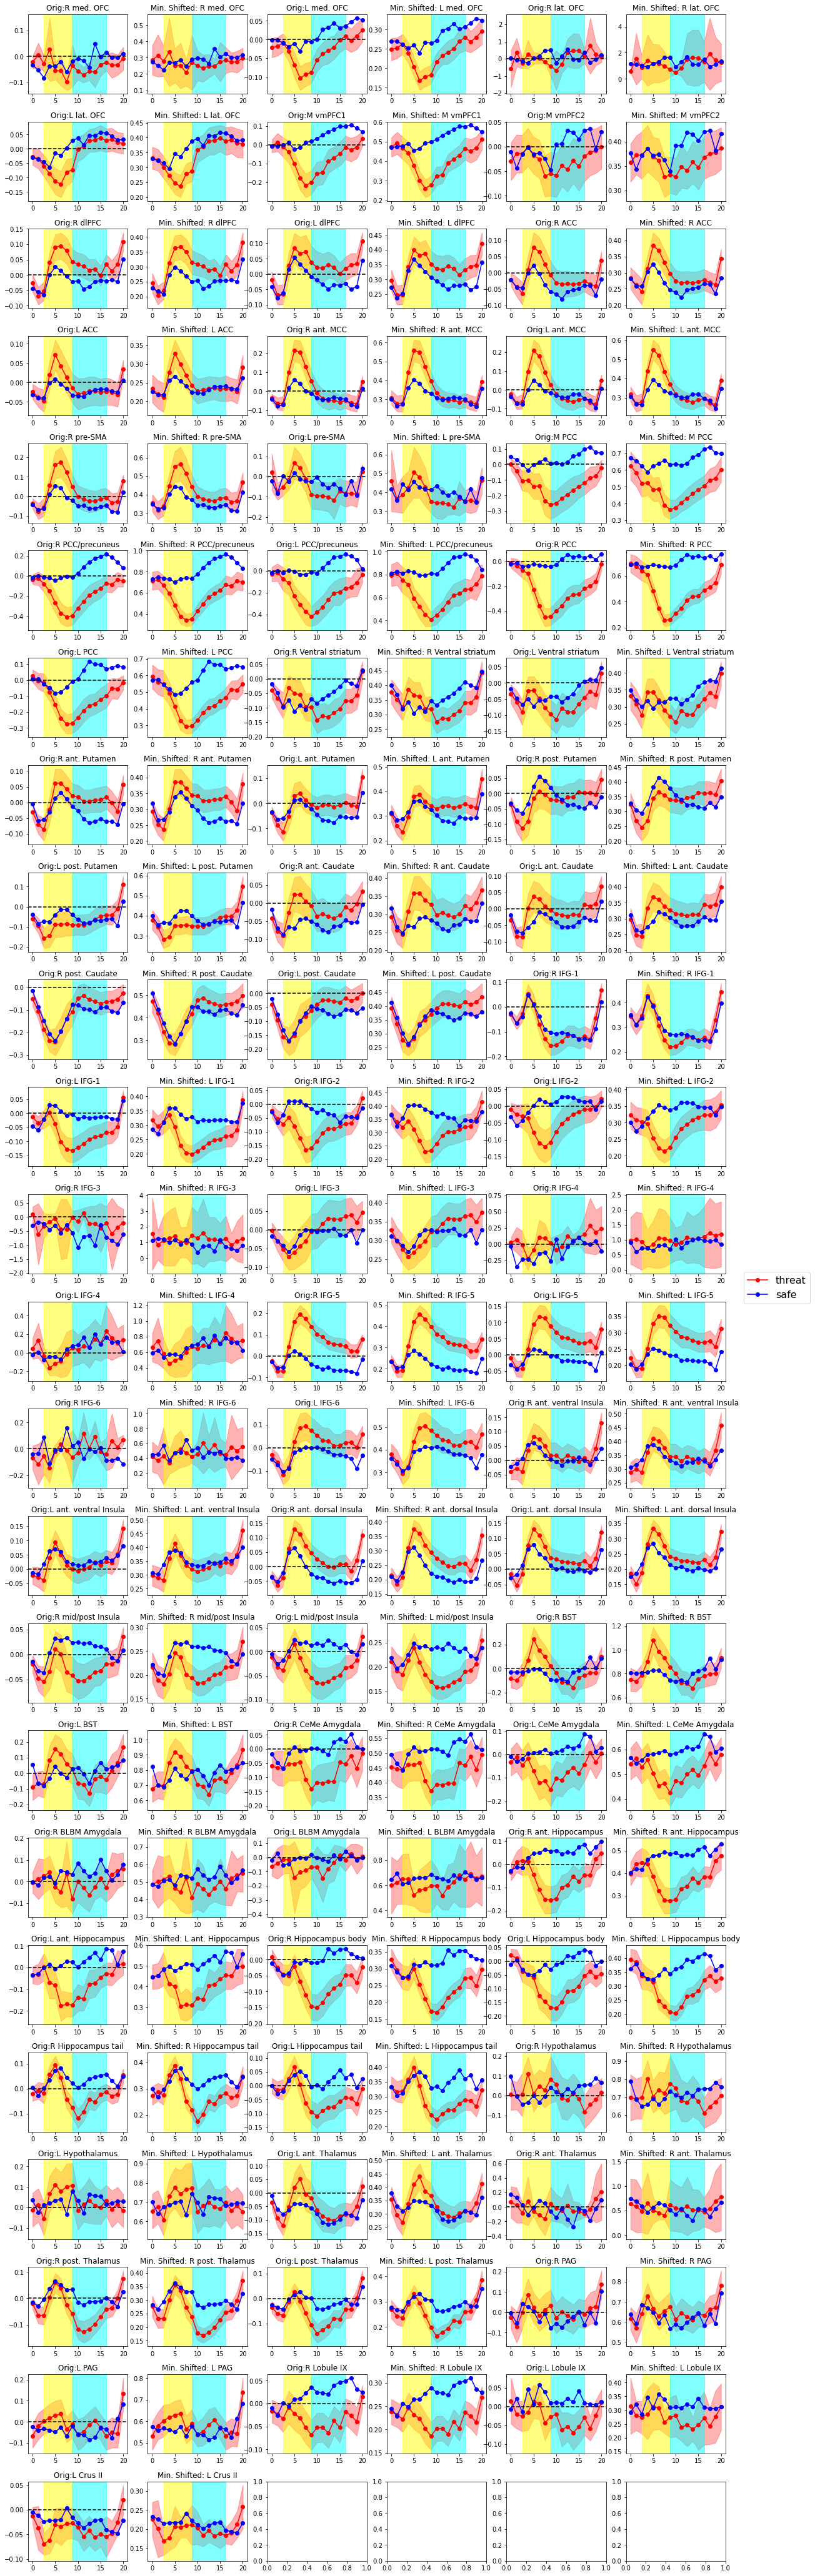

In [30]:
fig, axes = plt.subplots(nrows=24,ncols=6,figsize=(20,75),sharey=False)
axes = axes.flatten()
fig.subplots_adjust(wspace=0.2,hspace=0.35)

for i, roi in enumerate(rois):
    ii = i*2
    
    orig_threat_df = orig_mean_df[(orig_mean_df['ROI']==roi) & (orig_mean_df['Type']=='threat')]
    orig_safe_df = orig_mean_df[(orig_mean_df['ROI']==roi) & (orig_mean_df['Type']=='safe')]
    axes[ii].plot(t,orig_threat_df['mean'],label='threat',color='red',marker='o')
    axes[ii].fill_between(t,orig_threat_df['lower_bound'],orig_threat_df['upper_bound'],alpha=0.3,color='red')
    axes[ii].plot(t,orig_safe_df['mean'],label='safe',color='blue',marker='o')
    axes[ii].axhline(y=0,linestyle='--',color='k')
    axes[ii].axvspan(xmin=2.5,xmax=8.75,color='yellow',alpha=0.5)
    axes[ii].axvspan(xmin=8.75,xmax=16.25,color='cyan',alpha=0.5)
    axes[ii].set_title('Orig:'+roi)
    
    
    offset_threat_df = offset_mean_df[(offset_mean_df['ROI']==roi) & (offset_mean_df['Type']=='threat')]
    offset_safe_df = offset_mean_df[(offset_mean_df['ROI']==roi) & (offset_mean_df['Type']=='safe')]
    axes[ii+1].plot(t,offset_threat_df['mean'],label='threat',color='red',marker='o')
    axes[ii+1].fill_between(t,offset_threat_df['lower_bound'],offset_threat_df['upper_bound'],alpha=0.3,color='red')
    axes[ii+1].plot(t,offset_safe_df['mean'],label='safe',color='blue',marker='o')
    axes[ii+1].axvspan(xmin=2.5,xmax=8.75,color='yellow',alpha=0.5)
    axes[ii+1].axvspan(xmin=8.75,xmax=16.25,color='cyan',alpha=0.5)
    axes[ii+1].set_title('Min. Shifted: '+roi)
    
_=fig.legend(axes[i].get_legend_handles_labels()[1],loc='center right',fontsize=16)

## STAI scores

In this section, STAI scores are standardized and added to the dataset

In [15]:
import re

STAI_path = '/data/bswift-1/Pessoa_Lab/MAX/dataset/behavioral/STAI_sums'
 
with open(STAI_path,'r') as file:
    names = re.split('\t| |\n',file.readline())

STAI=pd.read_csv(STAI_path,sep='\t',names=names[:3],skiprows=1)
STAI['Subj'] = STAI['subject'].apply(lambda ID: 'MAX{:03d}'.format(ID))
STAI.drop('subject',axis=1,inplace=True)
STAI = STAI[STAI.Subj.isin(df.Subj)]
STAI.set_index('Subj',inplace=True)
STAI.head()

,TRAIT,STATE
Subj,,
MAX101,27,22
MAX102,47,44
MAX103,33,32
MAX104,24,21
MAX105,56,28


In [16]:
# Standardize the covariates
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
STAI = pd.DataFrame(ss.fit_transform(STAI),columns=STAI.columns,index=STAI.index)
STAI.reset_index(inplace=True)
STAI.head()

,Subj,TRAIT,STATE
0,MAX101,-1.164152,-1.011495
1,MAX102,1.264414,1.539046
2,MAX103,-0.435582,0.147842
3,MAX104,-1.528437,-1.127429
4,MAX105,2.357268,-0.315893


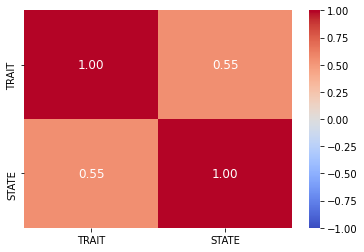

In [17]:
# Trait-State correlation 
_=sns.heatmap(STAI.corr(method='spearman'),vmin=-1,vmax=1,annot=True,fmt='.2f',cmap='coolwarm',annot_kws=dict(size=12))

## Aggregate Early/Late Periods 

This notebook aggregates responses from early (2.5-8.75s) and late periods (10-16.25s)

In [18]:
def phase(time):
    if (time >= 2.5 and time <= 8.75):
        return 'early'
    elif (time >= 10 and time <= 16.25):
        return 'late'
    else:
        return np.nan

In [19]:
# Add a phase column (early.late)
offset_df['Phase'] = offset_df['Time'].apply(phase)
offset_df.dropna(inplace=True)
offset_df.head()

,Subj,Type,Time,ROI,beta,var,Phase
2,MAX101,threat,2.50,R med. OFC,0.265359,0.007625,early
3,MAX101,threat,3.75,R med. OFC,0.274967,0.007735,early
4,MAX101,threat,5.00,R med. OFC,0.085874,0.007817,early
5,MAX101,threat,6.25,R med. OFC,0.108975,0.007938,early
6,MAX101,threat,7.50,R med. OFC,0.081014,0.007946,early


In [20]:
agg_df = offset_df.groupby(['Subj','Type','ROI','Phase'])['beta'].sum()
agg_df = agg_df.to_frame(name="beta").reset_index()
agg_df = agg_df.merge(STAI)
agg_df.head()

,Subj,Type,ROI,Phase,beta,TRAIT,STATE
0,MAX101,safe,L ACC,early,0.845514,-1.164152,-1.011495
1,MAX101,safe,L ACC,late,0.832510,-1.164152,-1.011495
2,MAX101,safe,L BLBM Amygdala,early,2.732654,-1.164152,-1.011495
3,MAX101,safe,L BLBM Amygdala,late,3.669231,-1.164152,-1.011495
4,MAX101,safe,L BST,early,3.940520,-1.164152,-1.011495


In [21]:
agg_df['cond'] = agg_df['Type'].apply(lambda a: -0.5 if a=='safe' else 0.5)
agg_df.head()

,Subj,Type,ROI,Phase,beta,TRAIT,STATE,cond
0,MAX101,safe,L ACC,early,0.845514,-1.164152,-1.011495,-0.5
1,MAX101,safe,L ACC,late,0.832510,-1.164152,-1.011495,-0.5
2,MAX101,safe,L BLBM Amygdala,early,2.732654,-1.164152,-1.011495,-0.5
3,MAX101,safe,L BLBM Amygdala,late,3.669231,-1.164152,-1.011495,-0.5
4,MAX101,safe,L BST,early,3.940520,-1.164152,-1.011495,-0.5


In [22]:
if not exists('data/MAX_neutral_early_late_offset_agg.txt'):
    agg_df.to_csv('data/MAX_neutral_early_late_offset_agg.txt',sep=',',float_format='%.6f',index=False)

In [29]:
offset_df.sort_values(by='beta',ascending=False).head(10)

,Subj,Type,Time,ROI,beta,var,Phase
33415,MAX115,safe,12.50,R lat. OFC,125.56570,1187.532649,late
33412,MAX115,safe,8.75,R lat. OFC,124.49990,1176.650747,early
65391,MAX130,threat,11.25,R IFG-3,120.37018,1106.865165,late
33411,MAX115,safe,7.50,R lat. OFC,119.79380,1176.872530,early
33399,MAX115,threat,13.75,R lat. OFC,118.72460,1183.676361,late
33400,MAX115,threat,15.00,R lat. OFC,117.96390,1190.750191,late
33391,MAX115,threat,3.75,R lat. OFC,108.31000,1192.714843,early
33398,MAX115,threat,12.50,R lat. OFC,107.56550,1198.280612,late
33418,MAX115,safe,16.25,R lat. OFC,103.43590,1189.864920,late
65386,MAX130,threat,5.00,R IFG-3,102.03598,1094.309198,early


In [36]:
df.sort_values(by='beta',ascending=False).head(50)

,Subj,Type,Time,ROI,beta,var
33402,MAX115,threat,17.50,R lat. OFC,89.35610,1217.987836
33415,MAX115,safe,12.50,R lat. OFC,62.30200,1187.532649
33412,MAX115,safe,8.75,R lat. OFC,61.23620,1176.650747
33411,MAX115,safe,7.50,R lat. OFC,56.53010,1176.872530
33399,MAX115,threat,13.75,R lat. OFC,55.46090,1183.676361
33400,MAX115,threat,15.00,R lat. OFC,54.70020,1190.750191
33389,MAX115,threat,1.25,R lat. OFC,45.96130,1153.256327
33391,MAX115,threat,3.75,R lat. OFC,45.04630,1192.714843
33398,MAX115,threat,12.50,R lat. OFC,44.30180,1198.280612
33418,MAX115,safe,16.25,R lat. OFC,40.17220,1189.864920
